In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import logging 
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from collections import defaultdict
from math import sqrt
from multiprocessing.dummy import Pool as ThreadPool 
import numpy as np
from vanet_tools import plot_microclouds,Block,Node,Microcloud,create_coords,simulation

In [5]:
df = pd.read_csv("new_york.csv",delimiter=";").dropna()

We have to check if the simulation ended with some cars still on it. The last second in the simulation as reported in the SUMO-GUI was around 4600s.

In [15]:
max_time = df['timestep_time'].max()
max_time

4468.0

Therefore, all the cars departed before the simulation finished

In [6]:
car_groups = df.sort_values(by='timestep_time').groupby('vehicle_id')

In [7]:
CARS = df['vehicle_id'].unique()

In [6]:
car0_df = car_groups.get_group(CARS[0])
car0_df.head()

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y
0,0.0,208.92,veh0,46525058#0_0,5.10,0.0,0.00,passenger,3764.34,5531.80
1,1.0,208.92,veh0,46525058#0_0,6.54,0.0,1.44,passenger,3763.65,5530.53
3,2.0,208.92,veh0,46525058#0_0,10.52,0.0,3.98,passenger,3761.72,5527.05
6,3.0,208.92,veh0,46525058#0_0,16.34,0.0,5.82,passenger,3758.91,5521.96
9,4.0,208.92,veh0,46525058#0_0,24.43,0.0,8.09,passenger,3754.99,5514.87


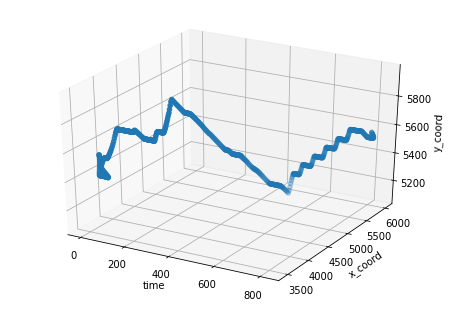

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(car0_df['timestep_time'],car0_df['vehicle_x'] , car0_df['vehicle_y'])
ax.set_xlabel("time")
ax.set_ylabel("x_coord")
ax.set_zlabel("y_coord")
plt.show()

In [8]:
coordinates = df[['vehicle_x','vehicle_y']]

In [9]:
coords_x,coords_y = coordinates['vehicle_x'],coordinates['vehicle_y']

In [21]:
coords_x.min(),coords_y.min()

(2709.8, 3612.22)

In [12]:
coords_x.max(),coords_y.max()

(7535.23, 8296.82)

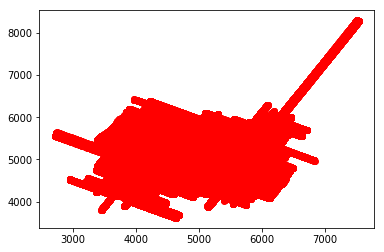

In [13]:
plt.scatter(coords_x,coords_y,c='red')
plt.show()

Below we will place the mircroclouds into the grid.Our algorithm for doing so works as follows. We will get a random coordinate and see if that coordinate collides overlaps with any of the current coordinates for the microclouds, if it does not the position is added onto the array as a position for a microcloud

In [10]:
MICROCLOUD_RANGE=150
NUM_MICROCLOUDS = 10

In [11]:
MICROCLOUD_COORDS = create_coords(coordinates,MICROCLOUD_RANGE,num_microclouds=NUM_MICROCLOUDS)

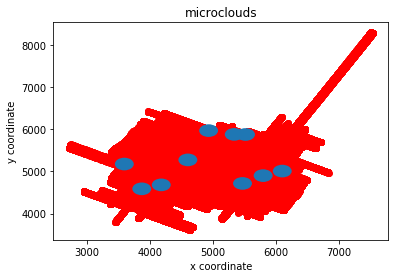

In [14]:
plot_microclouds(MICROCLOUD_COORDS,MICROCLOUD_RANGE,coords_x,coords_y)

In [12]:
#This is a test of the simulation with 1 car
logging.getLogger().setLevel(logging.DEBUG)
result = simulation(MICROCLOUD_COORDS,MICROCLOUD_RANGE,[CARS[0]],car_groups)

INFO:root:Finished setup started simulation with 10 microclouds
DEBUG:root:Id veh0
DEBUG:root:Time 0.0
DEBUG:root:Time 1.0
DEBUG:root:Time 2.0
DEBUG:root:Time 3.0
DEBUG:root:Time 4.0
DEBUG:root:Time 5.0
DEBUG:root:Time 6.0
DEBUG:root:Time 7.0
DEBUG:root:Time 8.0
DEBUG:root:Time 9.0
DEBUG:root:Time 10.0
DEBUG:root:Time 11.0
DEBUG:root:Time 12.0
DEBUG:root:Time 13.0
DEBUG:root:Time 14.0
DEBUG:root:Time 15.0
DEBUG:root:Time 16.0
DEBUG:root:Time 17.0
DEBUG:root:Time 18.0
DEBUG:root:Time 19.0
DEBUG:root:Time 20.0
DEBUG:root:Time 21.0
DEBUG:root:Time 22.0
DEBUG:root:Time 23.0
DEBUG:root:Time 24.0
DEBUG:root:Time 25.0
DEBUG:root:Time 26.0
DEBUG:root:Time 27.0
DEBUG:root:Time 28.0
DEBUG:root:Time 29.0
DEBUG:root:Time 30.0
DEBUG:root:Time 31.0
DEBUG:root:Time 32.0
DEBUG:root:Time 33.0
DEBUG:root:Time 34.0
DEBUG:root:Time 35.0
DEBUG:root:Time 36.0
DEBUG:root:Time 37.0
DEBUG:root:Time 38.0
DEBUG:root:Time 39.0
DEBUG:root:Time 40.0
DEBUG:root:Time 41.0
DEBUG:root:Time 42.0
DEBUG:root:Time 43.0
DEB

DEBUG:root:Time 374.0
DEBUG:root:Time 375.0
DEBUG:root:Time 376.0
DEBUG:root:Time 377.0
DEBUG:root:Time 378.0
DEBUG:root:Time 379.0
DEBUG:root:Time 380.0
DEBUG:root:Time 381.0
DEBUG:root:Time 382.0
DEBUG:root:Time 383.0
DEBUG:root:Time 384.0
DEBUG:root:Time 385.0
DEBUG:root:Time 386.0
DEBUG:root:Time 387.0
DEBUG:root:Time 388.0
DEBUG:root:Time 389.0
DEBUG:root:Time 390.0
DEBUG:root:Time 391.0
DEBUG:root:Time 392.0
DEBUG:root:Time 393.0
DEBUG:root:Time 394.0
DEBUG:root:Time 395.0
DEBUG:root:Time 396.0
DEBUG:root:Time 397.0
DEBUG:root:Time 398.0
DEBUG:root:Time 399.0
DEBUG:root:Time 400.0
DEBUG:root:Time 401.0
DEBUG:root:Time 402.0
DEBUG:root:Time 403.0
DEBUG:root:Time 404.0
DEBUG:root:Time 405.0
DEBUG:root:Time 406.0
DEBUG:root:Time 407.0
DEBUG:root:Time 408.0
DEBUG:root:Time 409.0
DEBUG:root:Time 410.0
DEBUG:root:Time 411.0
DEBUG:root:Time 412.0
DEBUG:root:Time 413.0
DEBUG:root:Time 414.0
DEBUG:root:Time 415.0
DEBUG:root:Time 416.0
DEBUG:root:Time 417.0
DEBUG:root:Time 418.0
DEBUG:root

DEBUG:root:Time 729.0
DEBUG:root:Continuing download for block 6 on car veh0 with microcloud 6 latest progress: 5
DEBUG:root:Download finished for block 6 on car veh0 with microcloud 6
DEBUG:root:Time 730.0
DEBUG:root:Initiated download for block 7 on car veh0 with microcloud 6
DEBUG:root:Time 731.0
DEBUG:root:Continuing download for block 7 on car veh0 with microcloud 6 latest progress: 1
DEBUG:root:Time 732.0
DEBUG:root:Continuing download for block 7 on car veh0 with microcloud 6 latest progress: 2
DEBUG:root:Time 733.0
DEBUG:root:Continuing download for block 7 on car veh0 with microcloud 6 latest progress: 3
DEBUG:root:Time 734.0
DEBUG:root:Continuing download for block 7 on car veh0 with microcloud 6 latest progress: 4
DEBUG:root:Time 735.0
DEBUG:root:Continuing download for block 7 on car veh0 with microcloud 6 latest progress: 5
DEBUG:root:Download finished for block 7 on car veh0 with microcloud 6
DEBUG:root:Time 736.0
DEBUG:root:Initiated download for block 8 on car veh0 with

In [13]:
result

[['veh0', 3]]

In [21]:
logging.getLogger().setLevel(logging.INFO)
results = simulation()

INFO:root:Finished setup started simulation with 10 microclouds


In [22]:
stats_df = pd.DataFrame(results,columns=['id','blocks_received','blocks_needed'])
stats_df

,id,blocks_received,blocks_needed
0,veh0,3,12
1,veh1,3,12
2,veh2,1,12
3,veh3,6,12
4,veh4,2,12
5,veh5,0,12
6,veh6,6,12
7,veh7,0,12
8,veh9,2,12
9,veh10,9,12


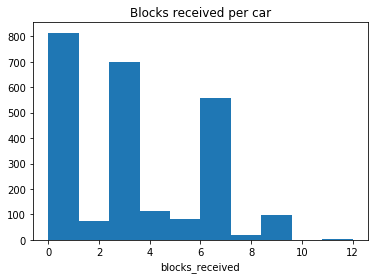

In [23]:
blocks_received = stats_df['blocks_received']
plt.xlabel("blocks_received")
plt.title("Blocks received per car")
plt.hist(stats_df['blocks_received'])
plt.show()

In [24]:
block_percentage = blocks_received.mean()/12
ninety_five_percentily = np.percentile(blocks_received,5)
block_percentage,ninety_five_percentily

(0.26207386363636365, 0.0)

In [14]:
def simulation_by_number_of_clouds(start=1,end=21,step=1):
    total_blocks =12
    logging.getLogger().setLevel(logging.INFO)
    stats = []
    for num_clouds in range(start,end,step):
        logging.info("Starting simulation with {} num of clouds".format(num_clouds))
        microclouds_coords = create_coords(coordinates,MICROCLOUD_RANGE,num_microclouds=num_clouds)
        results = simulation(microclouds_coords,MICROCLOUD_RANGE,CARS,car_groups)
        stats_df = pd.DataFrame(results,columns=['id','blocks_received','latency'])
        blocks_received = stats_df['blocks_received']
        block_percentage = blocks_received.mean()/total_blocks
        ninety_five_percentily = np.percentile(blocks_received,5)
        files_downloaded = len(stats_df['blocks_received']==total_blocks)
        average_latency = stats_df['latency'].mean()
        stats.append([num_clouds,block_percentage,ninety_five_percentily,files_downloaded,average_latency])
    return stats

In [32]:
stats = simulation_by_number_of_clouds()

INFO:root:Starting simulation with 1 num of clouds
INFO:root:Finished setup started simulation with 1 microclouds
INFO:root:Starting simulation with 2 num of clouds
INFO:root:Finished setup started simulation with 2 microclouds
INFO:root:Starting simulation with 3 num of clouds
INFO:root:Finished setup started simulation with 3 microclouds
INFO:root:Starting simulation with 4 num of clouds
INFO:root:Finished setup started simulation with 4 microclouds
INFO:root:Starting simulation with 5 num of clouds
INFO:root:Finished setup started simulation with 5 microclouds
INFO:root:Starting simulation with 6 num of clouds
INFO:root:Finished setup started simulation with 6 microclouds
INFO:root:Starting simulation with 7 num of clouds
INFO:root:Finished setup started simulation with 7 microclouds
INFO:root:Starting simulation with 8 num of clouds
INFO:root:Finished setup started simulation with 8 microclouds
INFO:root:Starting simulation with 9 num of clouds
INFO:root:Finished setup started simu

In [33]:
df_stats = pd.DataFrame(stats,columns=['num_clouds','block_percentage','ninety_five_percentile'])

In [34]:
df_stats

,num_clouds,block_percentage,ninety_five_percentile
0,1,0.030032,0.0
1,2,0.037202,0.0
2,3,0.056548,0.0
3,4,0.093378,0.0
4,5,0.131223,0.0
5,6,0.138697,0.0
6,7,0.186587,0.0
7,8,0.242018,0.0
8,9,0.226461,0.0
9,10,0.258185,0.0


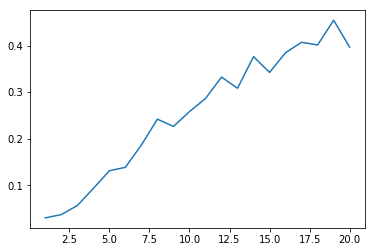

In [35]:
plt.plot(df_stats['num_clouds'],df_stats['block_percentage'])

In [36]:
df_stats.to_csv("microclouds_1_20")